In [22]:
import sys
sys.path.insert(1, '../src/')

import json, re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gemini_wrapper as gemini
import time

In [2]:
corpus = json.loads(open('../BData/corpus.json').read())

In [14]:
def extract_metrics(corpus, doc):
    data = [k for k in corpus if k['doc'] == doc]
    pages = len(data)
    if pages <= 0:
        return doc, 0, 0, 0
    
    lens = [len(k['txt']) for k in data]
    max_chars = max(lens)
    min_chars = min(lens)

    return doc, pages, max_chars, min_chars

def extract_json(txt):
    m = re.match('```json(.+)```', txt, re.DOTALL)
    if m is None:
        return txt
    
    return m.group(1).strip()   

def generate_question(context):
    qgen_template = open('../metadata/question_gen_prompt_sample.md').read()
    output_template = open('../metadata/question_gen_prompt_sample_out.json').read()
    prompt = qgen_template.format(output=output_template, context=context)
    r = gemini.ask(prompt)
    js = json.loads(extract_json(r))
    js['context'] = context

    return js    

In [5]:
total_docs = corpus[-1]['doc']+1
mtx = []
for i in range(total_docs):
    mtx.append(extract_metrics(corpus, i))

In [6]:
meta_df = pd.DataFrame(mtx, columns=['doc', 'pages', 'max_chars', 'min_chars'])
meta_df

,doc,pages,max_chars,min_chars
0,0,37,3019,332
1,1,1,3625,3625
2,2,8,5962,337
3,3,71,3154,346
4,4,1,1101,1101
...,...,...,...,...
604,604,4,3670,2430
605,605,135,7909,202
606,606,6,4231,2305
607,607,5,3144,1086


Text(0.5, 1.0, 'Density distribution of pages per text document.')

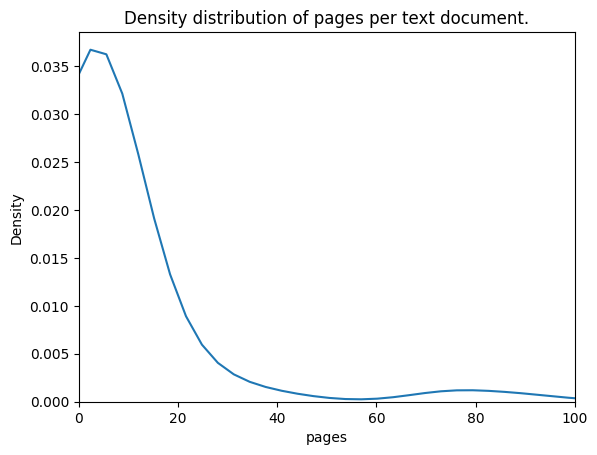

In [7]:
_, ax = plt.subplots()
ax.set_xlim([0, 100])
sns.kdeplot(meta_df.pages, ax=ax)
ax.set_title('Density distribution of pages per text document.')

In [8]:
gemini.configure()

In [23]:
question_db = []
nquestions = 100
for k in range(nquestions):
    w = len(corpus) // nquestions
    i = k * w
    doc, page = corpus[i]['doc'], corpus[i]['page']
    print(f'Generating question for doc {doc}, page {page}')
    context = corpus[i]['txt']
    js = generate_question(context)
    js['doc'] = doc
    js['page'] = page

    question_db.append(js)

    time.sleep(5)

print('finished')

Generating question for doc 0, page 0
Generating question for doc 3, page 21
Generating question for doc 5, page 20
Generating question for doc 5, page 87
Generating question for doc 5, page 154
Generating question for doc 5, page 221
Generating question for doc 5, page 288
Generating question for doc 5, page 355
Generating question for doc 5, page 423
Generating question for doc 5, page 490
Generating question for doc 5, page 557
Generating question for doc 8, page 8
Generating question for doc 12, page 17
Generating question for doc 19, page 33
Generating question for doc 19, page 112
Generating question for doc 78, page 0
Generating question for doc 90, page 3
Generating question for doc 100, page 37
Generating question for doc 101, page 10
Generating question for doc 112, page 3
Generating question for doc 117, page 43


KeyboardInterrupt: 

In [21]:
r = gemini.ask('Greetings, how are you doing?')
print(r)

I am doing well, thank you for asking!  How are you today?



In [26]:
open('../logs/questions.json', 'w+').write(json.dumps(question_db))

55651